# Problem 3

3. Try to track the shortest path computed in Prob. 1 with the car in Prob. 2. Show the actual resulting
trajectory of the car.

pure-pursuit part of the code based on AtsushiSakai's code

link : https://github.com/AtsushiSakai/PythonRobotics/blob/master/PathTracking/pure_pursuit/pure_pursuit.py

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
import matplotlib.patches as patches
import math

In [26]:
occ_map = np.array([[0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1],
            [0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
            [0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],
            [0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,1,1,1,0,0,0,1],
            [1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1],
            [1,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1],
            [1,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1],
            [1,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,1,1,1,1,1,1,1,1,1],
            [1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1],
            [1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1],
            [1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1],
            [0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1],
            [0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1],
            [0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1],
            [0,0,0,0,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,1]])

a_star_grid_path = [(0, 2), (1, 3), (2, 3), (3, 3), (4, 3), (5, 3), (6, 3), (7, 3), (8, 4), (8, 5), (8, 6), (7, 7), (6, 8), (5, 9), (4, 10), (3, 11), (2, 12), (3, 13), (4, 14), (5, 15), (6, 15), (7, 15), (8, 15), (9, 15), (10, 15), (11, 16), (11, 17), (11, 18), (10, 19), (10, 20), (11, 21), (12, 22), (13, 22), (14, 22)]
a_star_path = [(j+0.5, i+0.5) for i, j in a_star_grid_path]


In [27]:
# Parameters
lookahead_distance = 1.0  # [m] look-ahead distance
Kp = 1.0  # speed proportional gain
dt = 0.01  # [s] time tick

In [28]:
class State:
    def __init__(self, x=0.0, y=0.0, yaw=0.0, v=1.0, w=0.0):
        self.x = x
        self.y = y
        self.yaw = yaw
        self.v = v
        self.w = w

    def update(self,v,w):
        self.v = v;
        self.w = w;
        self.x += v * math.cos(self.yaw) * dt
        self.y += v * math.sin(self.yaw) * dt
        self.yaw += w * dt

    def calc_distance(self, point_x, point_y):
        dx = self.x - point_x
        dy = self.y - point_y
        return math.hypot(dx, dy)

In [29]:
class States:
    def __init__(self):
        self.x = []
        self.y = []
        self.yaw = []
        self.v = []
        self.w = []
        self.t = []

    def append(self, t, state):
        self.x.append(state.x)
        self.y.append(state.y)
        self.yaw.append(state.yaw)
        self.v.append(state.v)
        self.w.append(state.w)
        self.t.append(t)

In [30]:
def proportional_control(target, current):
    a = Kp * (target - current)

    return a

In [31]:
class FollowPath:
    def __init__(self, path_x, path_y):
        self.path_x = path_x
        self.path_y= path_y
        self.old_nearest_point_index = None

    def search_target_index(self, state):
        # To speed up nearest point search, doing it at only first time.
        if self.old_nearest_point_index is None:
            # search nearest point index
            dx = [state.x - icx for icx in self.path_x]
            dy = [state.y - icy for icy in self.path_y]
            d = np.hypot(dx, dy)
            ind = np.argmin(d)
            self.old_nearest_point_index = ind
        else:
            ind = self.old_nearest_point_index
            distance_this_index = state.calc_distance(self.path_x[ind],self.path_y[ind])
            while True:
                if ind + 1 >= len(self.path_x):
                    break
                distance_next_index = state.calc_distance(self.path_x[ind + 1],self.path_y[ind + 1])
                if distance_this_index < distance_next_index:
                    break
                ind = ind + 1 if (ind + 1) < len(self.path_x) else ind
                distance_this_index = distance_next_index
            self.old_nearest_point_index = ind

        # distance_to_ = k * state.v + Lfc  # update look ahead distance

        # search look ahead target point index
        while lookahead_distance > state.calc_distance(self.path_x[ind], self.path_y[ind]):
            if (ind + 1) >= len(self.path_x):
                break  # not exceed goal
            ind += 1

        return ind

In [32]:
def pure_pursuit_steer_control(state, trajectory, pind):
    target_speed = 0.1

    ind = trajectory.search_target_index(state)
    
    if pind >= ind:
        ind = pind

    if ind < len(trajectory.path_x)-1:
        tx = trajectory.path_x[ind]
        ty = trajectory.path_y[ind]
    else:  # toward goal
        tx = trajectory.path_x[-1]
        ty = trajectory.path_y[-1]
        ind = len(trajectory.path_x) - 1

    yaw_difference = math.atan2(ty - state.y, tx - state.x) - state.yaw
    if(abs(yaw_difference) > abs(yaw_difference - 2*math.pi)):
        yaw_difference = 2 * math.pi - abs(yaw_difference)
    if(abs(yaw_difference) > abs(2*math.pi + yaw_difference)):
        yaw_difference =2*math.pi + yaw_difference
    
    w = yaw_difference / math.pi # w in [-1. 1]
    v = target_speed

    print(f"current control: v ${v} w {w}")
    return v,w, ind

In [33]:
def plot_arrow(x, y, yaw, length=1.0, width=0.5, fc="r", ec="k"):
    """
    Plot arrow
    """

    if not isinstance(x, float):
        for ix, iy, iyaw in zip(x, y, yaw):
            plot_arrow(ix, iy, iyaw)
    else:
        plt.arrow(x, y, length * math.cos(yaw), length * math.sin(yaw),
                  fc=fc, ec=ec, head_width=width, head_length=width)
        plt.plot(x, y)

In [37]:
def pure_pursuit(path_x, path_y):
    T = 500.0  # max simulation time
    
    # initial state
    state = State(x=path_x[0], y=path_y[0], yaw=0.0, v=0.5, w=0.0)
    print("initial state:", state.x, state.y, state.yaw)
    print(len(path_x), len(path_y))
    
    lastIndex = len(path_x) - 1
    time = 0.0
    states = States()
    states.append(time, state)

    target_course = FollowPath(path_x, path_y)
    
    target_ind = target_course.search_target_index(state)

    while T >= time and lastIndex > target_ind:

        # Calc control input
        v, w, _ = pure_pursuit_steer_control(state, target_course, target_ind)
        
        state.update(v, w)  # Control vehicle

        time += dt
        states.append(time, state)
        if(state.x-path_x[-1])**2 + (state.y-path_y[-1])**2 < 0.1:
            break


    return states

    fig.cla()
    fig.plot(states.x, states.y, "-b", label="trajectory")

    # fig.subplots(1)
    # fig.plot(states.t, [iv * 3.6 for iv in states.v], "-r")
    # fig.xlabel("Time[s]")
    # fig.ylabel("Speed[km/h]")
    # fig.grid(True)
    # fig.show()
    
    # if show_animation:  # pragma: no cover
    #     plt.cla()
    #     plt.plot(cx, cy, ".r", label="course")
    #     plt.plot(states.x, states.y, "-b", label="trajectory")
    #     plt.legend()
    #     plt.xlabel("x[m]")
    #     plt.ylabel("y[m]")
    #     plt.axis("equal")
    #     plt.grid(True)

    #     plt.subplots(1)
    #     plt.plot(states.t, [iv * 3.6 for iv in states.v], "-r")
    #     plt.xlabel("Time[s]")
    #     plt.ylabel("Speed[km/h]")
    #     plt.grid(True)
    #     plt.show()



initial state: 2.5 0.5 0.0
34 34
current control: v $0.1 w 0.25
current control: v $0.1 w 0.2493634598316298
current control: v $0.1 w 0.24872870676264386
current control: v $0.1 w 0.24809573528512346
current control: v $0.1 w 0.24746453991131384
current control: v $0.1 w 0.24683511517352913
current control: v $0.1 w 0.24620745562405755
current control: v $0.1 w 0.24558155583506724
current control: v $0.1 w 0.24495741039851304
current control: v $0.1 w 0.2443350139260432
current control: v $0.1 w 0.24371436104890712
current control: v $0.1 w 0.2430954464178634
current control: v $0.1 w 0.24247826470308892
current control: v $0.1 w 0.24186281059408782
current control: v $0.1 w 0.24124907879960172
current control: v $0.1 w 0.2406370640475198
current control: v $0.1 w 0.2400267610847899
current control: v $0.1 w 0.23941816467733035
current control: v $0.1 w 0.23881126960994156
current control: v $0.1 w 0.238206070686219
current control: v $0.1 w 0.23760256272846614
current control: v $0.1

AttributeError: 'Figure' object has no attribute 'cla'

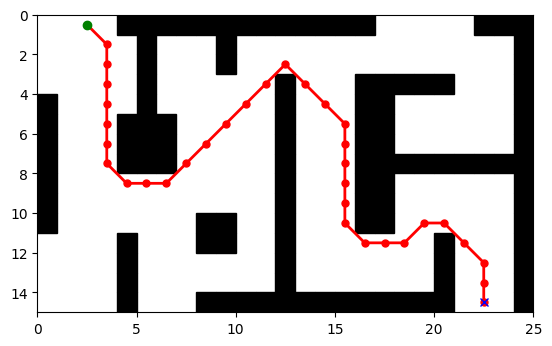

<Figure size 640x480 with 0 Axes>

In [38]:
## Plot everything
fig, ax = plt.subplots()
# Create a figure and an axes
ax.set_aspect('equal')
ax.margins(0)
ax.invert_yaxis()  # Invert the y-axis so that the first row of the grid is at the top


# Display the occupancy grid
for i in range(occ_map.shape[0]):
    for j in range(occ_map.shape[1]):
        if occ_map[i][j] == 1:
            # Adding a rectangle for each occupied cell
            ax.add_patch(patches.Rectangle((j, i), 1, 1, color='black'))
            
            
path_x = [ix for (ix, iy) in a_star_path]
path_y = [iy for (ix, iy) in a_star_path]

reverse_path_x = [ix for (ix, iy) in a_star_path[::-1]]
reverse_path_y = [iy for (ix, iy) in a_star_path[::-1]]

plt.plot(path_x, path_y, 'ro-', linewidth=2, markersize=5, label='Path')  # 'ro-' for red line with circle markers
plt.plot(path_x[0], path_y[0], 'go', label='Start')  # Mark the start with a green circle
plt.plot(path_x[-1], path_y[-1], 'bx', label='Goal')  # Mark the end with a blue 'x'

states = pure_pursuit(path_x, path_y)
plt.plot(states.x, states.y, "-b", label="trajectory")

reverse_states = pure_pursuit(reverse_path_x, reverse_path_y)
plt.plot(reverse_states.x, reverse_states.y, "-g", label="reverse trajectory")

# Adding labels and a title for clarity
ax.set_title('Occupancy Map')
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')

ax.set_xticks(np.arange(0, occ_map.shape[1], 1))
ax.set_yticks(np.arange(0, occ_map.shape[0], 1))
# ax.invert_yaxis()  # Invert the y-axis so that the first row of the grid is at the top
# Show the plot

plt.show()